# 3a A Visual Battery of Benchmarks

In [1]:
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm

## project specifics
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
jax.devices()

from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
from diffusion_curvature.comparison_space import *

%load_ext autoreload
%autoreload 2


# 3a A Visual Battery of Benchmarks

> 2 Manifolds, colored by curvature, neatly compared

Here is the curvature equivalent of the “sniff test”: does our technique
appropriately color the most basic 2 manifolds? This notebook implements
this comparison, making it easy to swap in and out curvature methods and
rerun them on every baseline.

In [117]:
# Establish Datasets
n_points = 5000
Xs = {}
Ks = {}
Xs['Torus'], Ks['Torus'] = torus(n_points, use_guide_points=False)
Xs['plane'] = np.hstack([plane(n_points, dim=2),np.zeros((n_points,1))])
Ks['plane'] = np.zeros(len(Xs['plane']))
Xs['Saddle'], Ks['Saddle'] = paraboloid(n_points, use_guide_points=False)
Xs['sphere'], Ks['sphere'] = sphere(n_points)
Xs['Ellipsoid'], Ks['Ellipsoid'] = ellispoid(n_points)
Xs['hyperboloid'], Ks['hyperboloid'] = hyperboloid(n_points)

In [118]:
from diffusion_curvature.kernels import gaussian_kernel
def fixed_median_heuristic_graph_former(X, alpha):
    W = gaussian_kernel(
        X, 
        kernel_type = "fixed",
        sigma = None, # use median heuristic
        anisotropic_density_normalization = alpha,
        threshold_for_small_values = 1e-8,
    )
    # set diagonal of W to zero
    np.fill_diagonal(W, 0)
    G = pygsp.graphs.Graph(W)
    return G

In [119]:
# graph_former = partial(fixed_graph_former, sigma = 0.05, alpha = 1)
graph_former = partial(get_adaptive_graph, k=5, alpha=1)
# graph_former = partial(fixed_median_heuristic_graph_former,alpha=1)
DC = DiffusionCurvature(
    laziness_method="Wasserstein",
    flattening_method="Fixed",
    comparison_method="Subtraction",
    graph_former = graph_former,
)

# Run on Toy Datasets

In [120]:
diffusion_ks = {}

2024-04-12 10:53:41,282:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-04-12 10:53:51,273:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-04-12 10:54:03,309:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-04-12 10:54:12,610:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-04-12 10:54:22,230:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-04-12 10:54:31,418:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-04-12 10:54:40,908:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-04-12 10:54:50,145:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-04-12 10:55:00,136:[WARNING](pygsp.graphs.graph.che

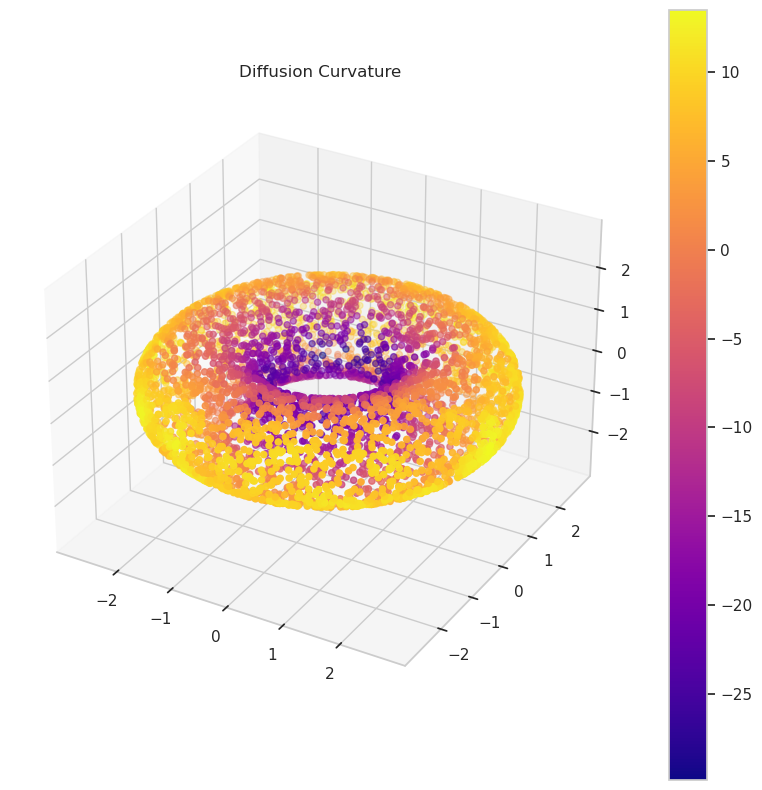

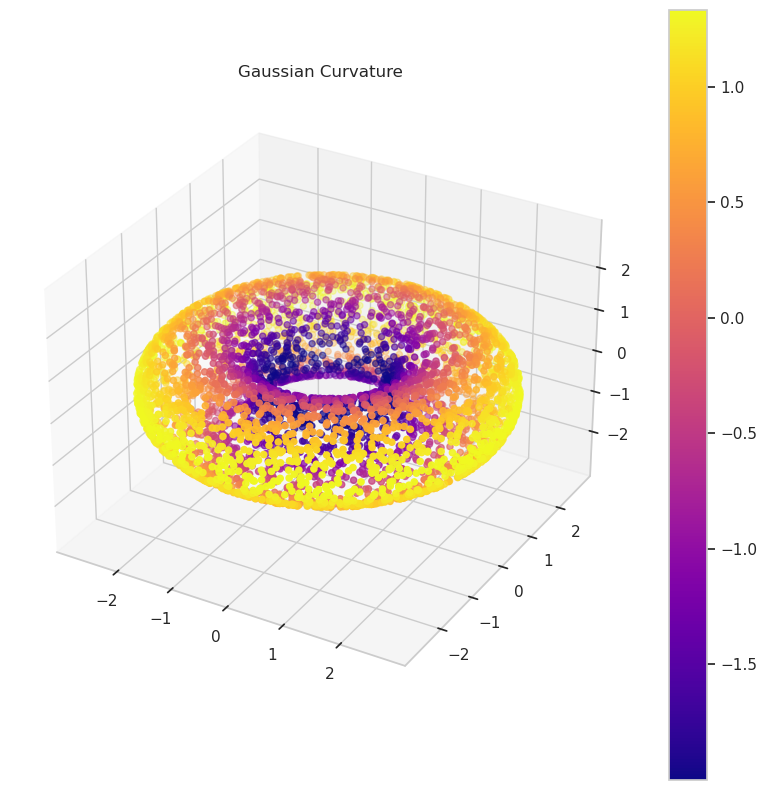

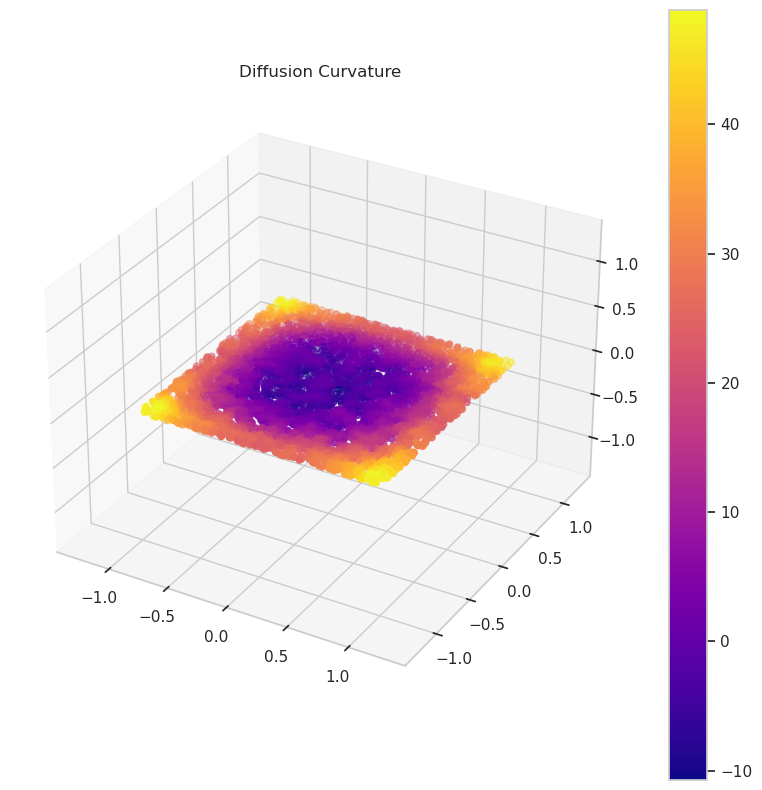

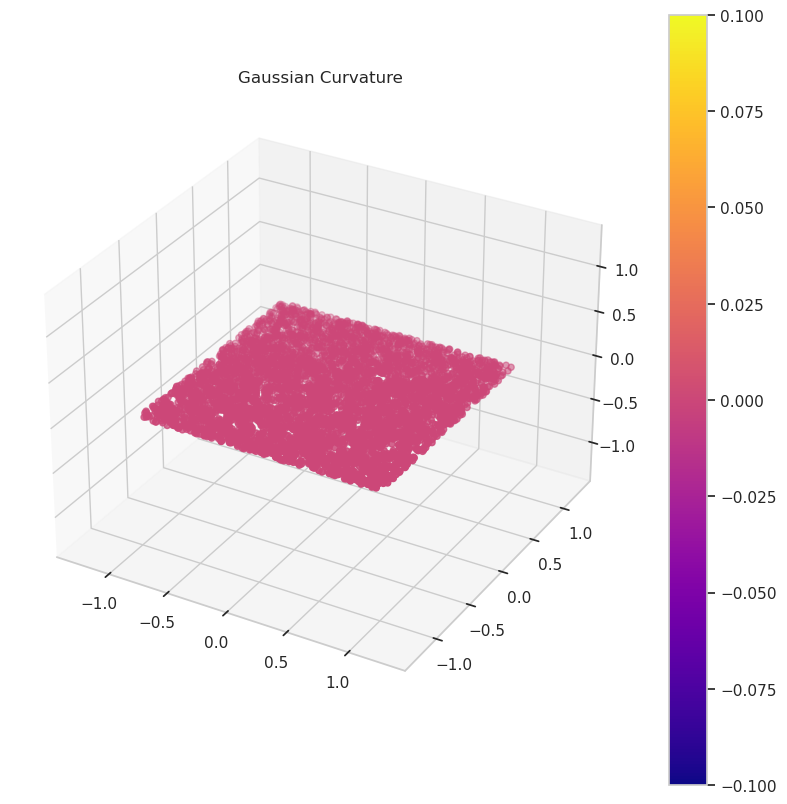

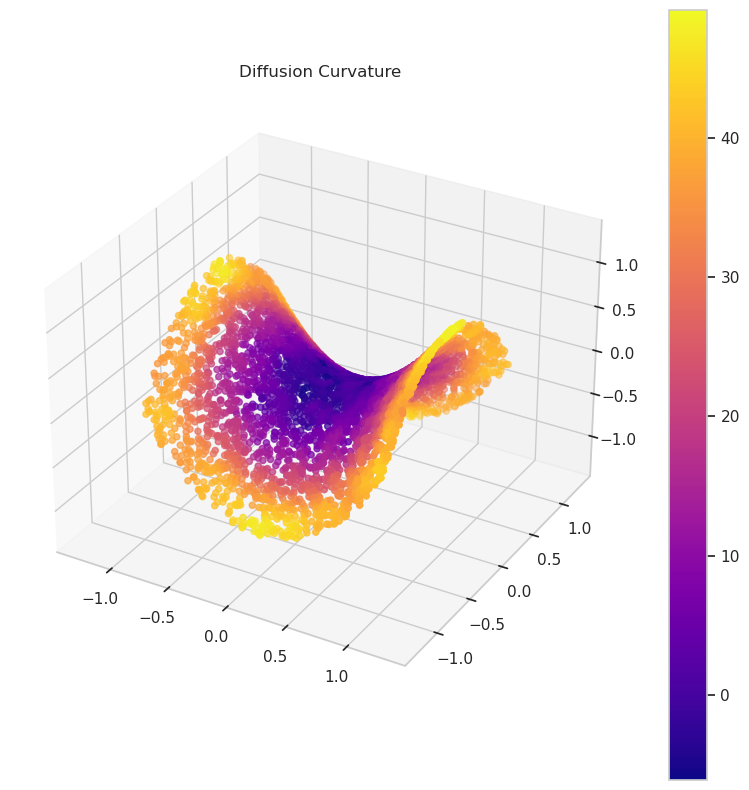

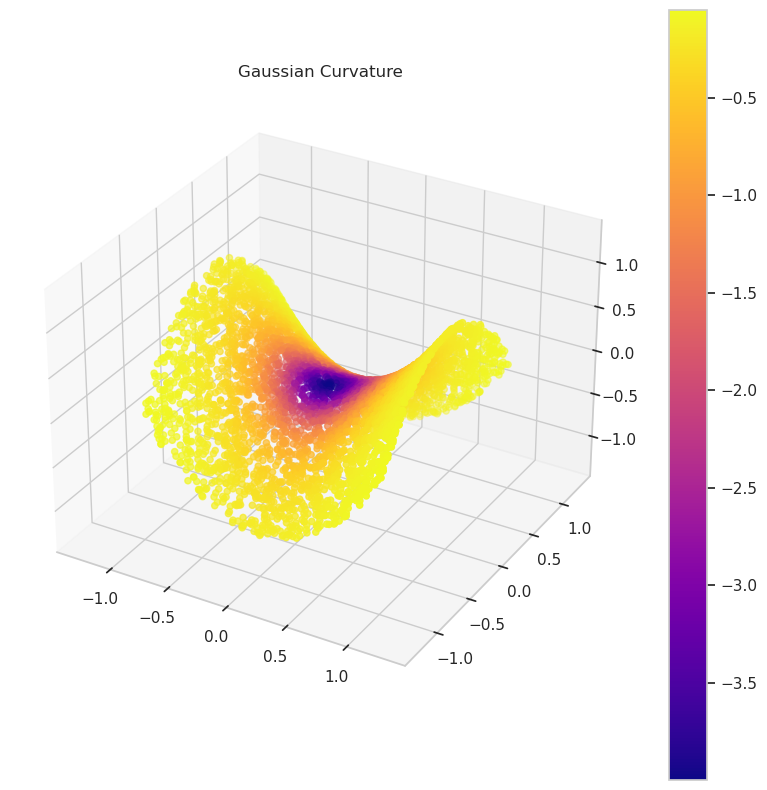

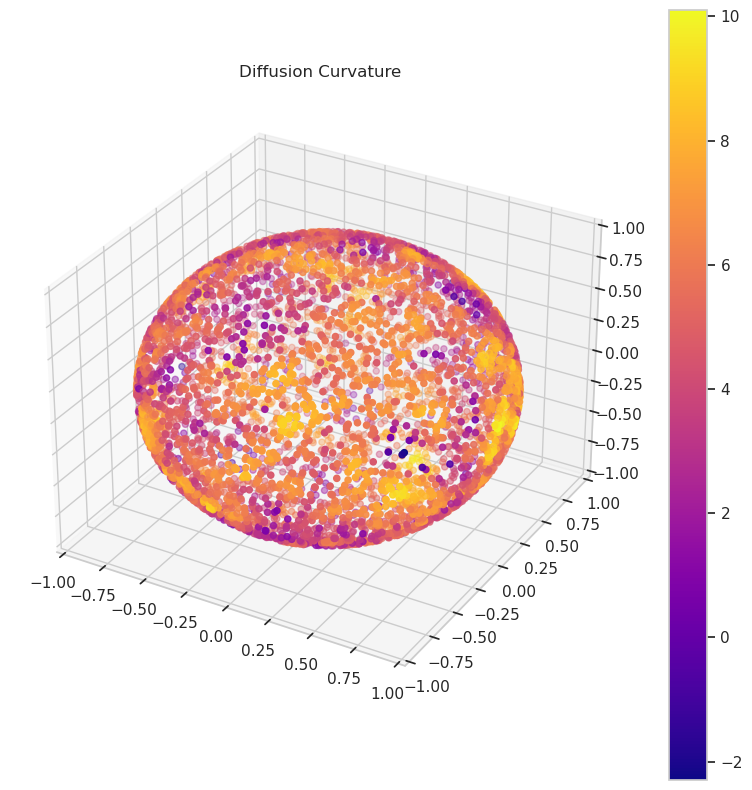

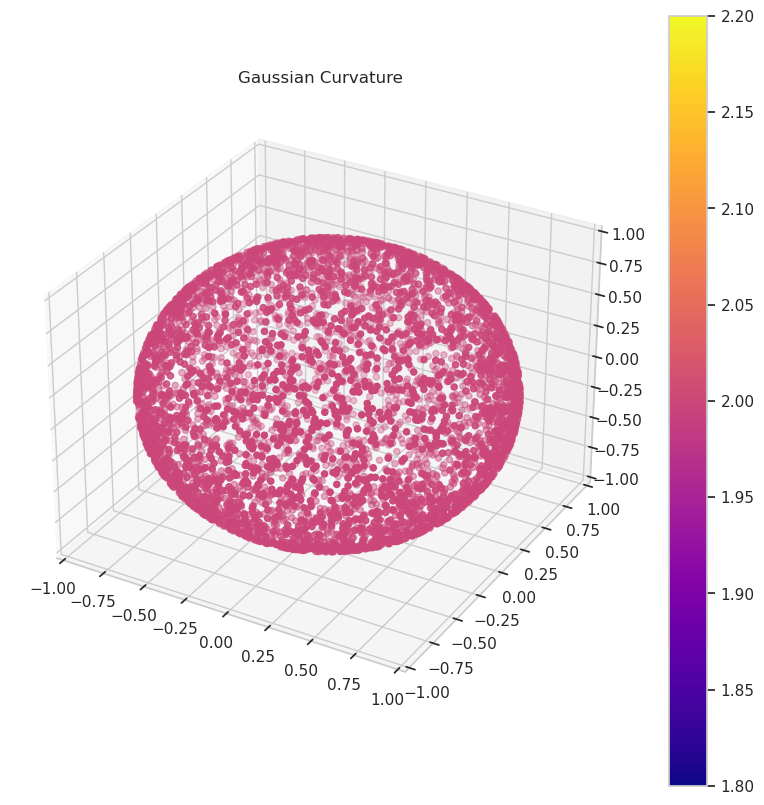

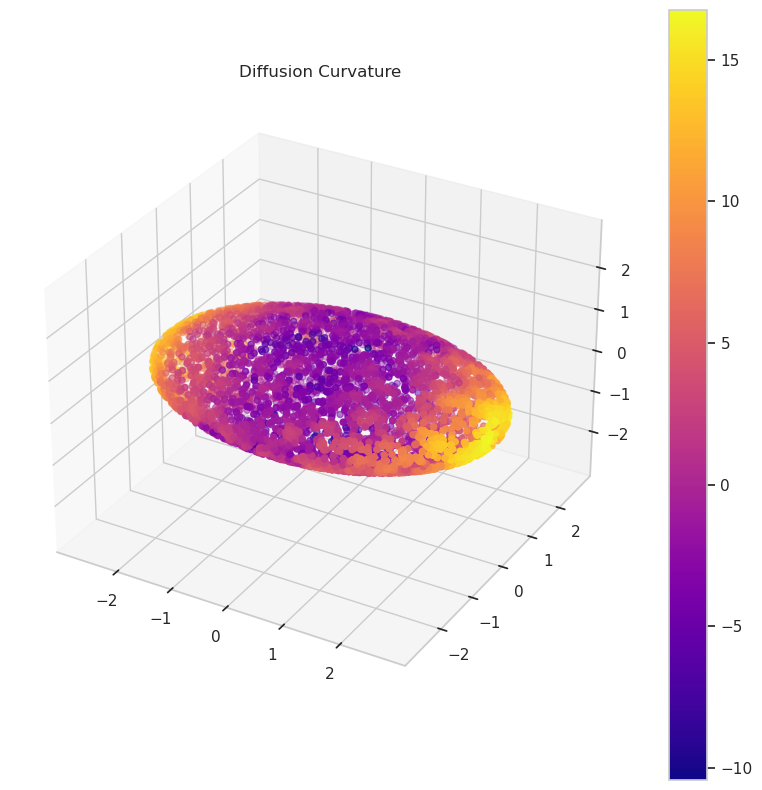

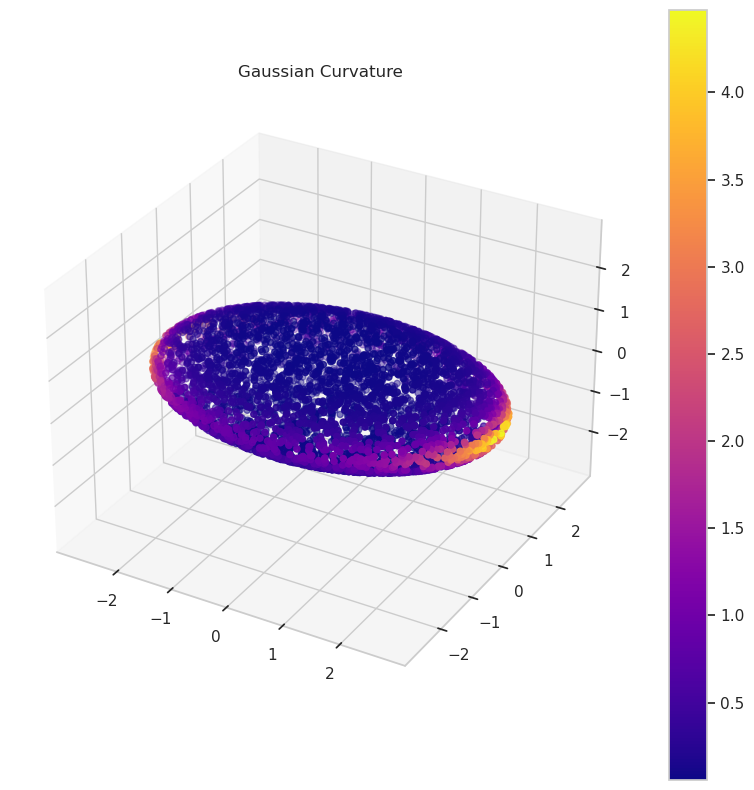

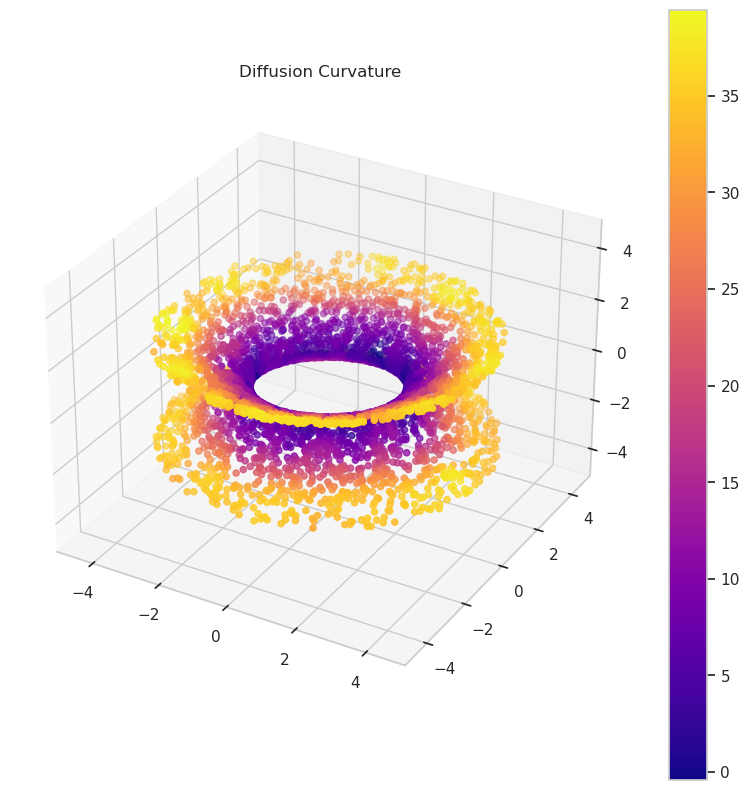

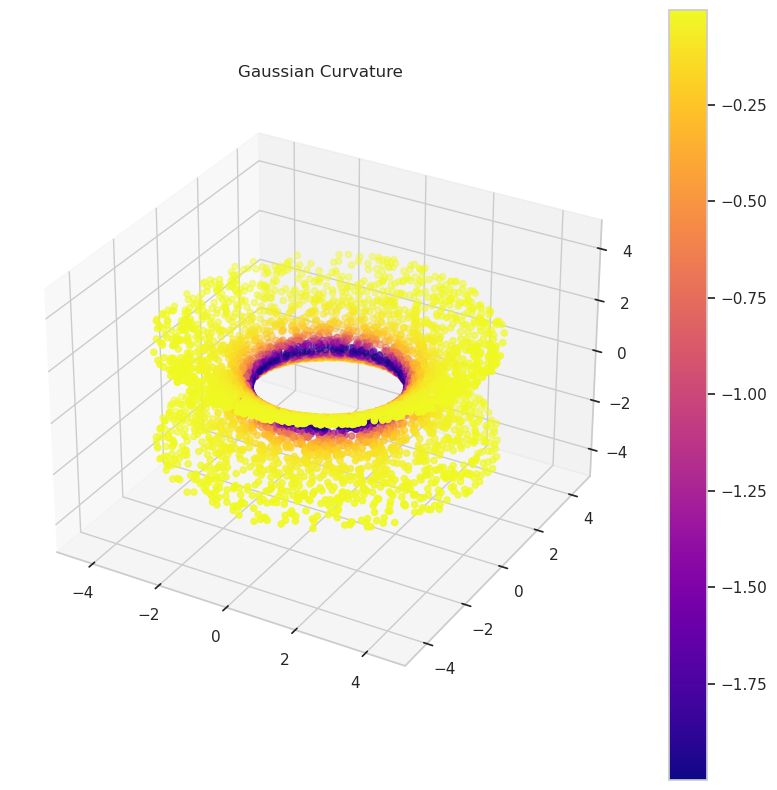

In [121]:
for dname in Xs.keys():
    X = Xs[dname]
    G = graph_former(X)
    ks_computed = DC.curvature(G, dim=2, t=25)
    diffusion_ks[dname] = ks_computed
    plot_3d(X, ks_computed, title = "Diffusion Curvature", colorbar=True)
    plot_3d(X, Ks[dname], title = "Gaussian Curvature", colorbar=True)


# Figure

In [138]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import colors
import numpy as np

# Assuming Xs, labels, ground_truth_labels, and key_names are defined
# For example:
key_names = ['Torus', 'Saddle', 'Ellipsoid']
labels = diffusion_ks
ground_truth_labels = Ks

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a figure and axes with 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(20, 12), subplot_kw={'projection': '3d'} if plt.matplotlib.__version__ < '3.4.0' else None)

for i, key in enumerate(key_names):
    # 3D scatter plot for the first row
    lim = np.max(np.linalg.norm(Xs[key], axis=1))
    if plt.matplotlib.__version__ >= '3.4.0':
        axs[0, i].remove()
        axs[0, i] = fig.add_subplot(2, 3, i+1, projection='3d')

    axs[0, i].axes.set_xlim3d(left=-lim, right=lim)
    axs[0, i].axes.set_ylim3d(bottom=-lim, top=lim)
    axs[0, i].axes.set_zlim3d(bottom=-lim, top=lim)
    scatter3d = axs[0, i].scatter(Xs[key][:, 0], Xs[key][:, 1], Xs[key][:, 2], c=labels[key], cmap='magma')
    axs[0, i].set_title(f'{key}',fontsize=15)

    # Scatter plot for the second row, colored by labels
    axs[1, i].remove()
    axs[1, i] = fig.add_subplot(2, 3, i+4)
    scatter2d = axs[1, i].scatter(ground_truth_labels[key], labels[key], c=labels[key], cmap='magma')
    # axs[1, i].set_title(f'')
    axs[1, i].set_xlabel('Gaussian Curvature')
    axs[1, i].set_ylabel('Diffusion Curvature')
    
    # Highlight the origin lines in 2D scatter plots
    axs[1, i].axhline(0, color='gray', linewidth=1, linestyle='--')
    axs[1, i].axvline(0, color='gray', linewidth=1, linestyle='--')

    # # Add colorbar for each subplot
    # fig.colorbar(scatter3d, ax=axs[0, i], fraction=0.046, pad=0.04)
    # fig.colorbar(scatter2d, ax=axs[1, i], fraction=0.046, pad=0.04)
plt.suptitle("Diffusion Curvature on 2 Manifolds", fontsize=30)
plt.tight_layout()
plt.show()


# Curvature Across Time

In [ ]:
from diffusion_curvature.comparison_space import *

## With Same parameter fitting

In [ ]:
G_plane = get_alpha_decay_graph(Xs['plane'], knn=30, anisotropy=1, )
G_flat = euclidean_comparison_graph(G_plane,dimension=2)
P = diffusion_matrix_from_affinities(G_plane.K.todense())
plt.scatter(Xs['plane'][:,0],Xs['plane'][:,1],c=P[0])
ts = np.arange(1,20)
DC = DiffusionCurvature(laziness_method="Entropic",comparison_space_size_factor=2,comparison_method="Subtraction",use_graphs_kernel_parameters=False)
uks = []
flat_uks = []
for t in tqdm(ts):
    uks += [float(DC.unsigned_curvature(G_plane,t)[0])]
    flat_uks += [float(DC.unsigned_curvature(G_flat,t)[0])]

In [ ]:
G_flat.get_params()

{'n_pca': None,
 'random_state': None,
 'kernel_symm': '+',
 'theta': None,
 'anisotropy': 0,
 'knn': 5,
 'decay': 40,
 'bandwidth': None,
 'bandwidth_scale': 1.0,
 'distance': 'euclidean',
 'precomputed': 'affinity'}

In [ ]:
G_plane.get_params()

{'n_pca': None,
 'random_state': None,
 'kernel_symm': '+',
 'theta': None,
 'anisotropy': 0,
 'knn': 5,
 'decay': 40,
 'bandwidth': None,
 'bandwidth_scale': 1.0,
 'distance': 'euclidean',
 'precomputed': 'affinity'}

In [ ]:
# plot uks and flat_uks on the same graph, with labels
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs[0].plot(ts,uks,label="Plane")
axs[0].plot(ts,flat_uks,label="Flat")
axs[0].legend()

axs[0].set_ylabel("Unsigned Curvature")
axs[0].set_title("Unsigned Curvature of Plane and Flat")

# Plot the ratio flat_uks/uks
axs[1].plot(ts,np.array(flat_uks)/np.array(uks))
axs[1].set_xlabel("t")
axs[1].set_ylabel("Unsigned Curvature")    
axs[1].set_title("Ratio of Flat to Plane")

plt.show()

In [ ]:
G_plane = get_alpha_decay_graph(Xs['plane'], knn=30, anisotropy=1, )
G_flat = euclidean_comparison_graph(G_plane,dimension=2)
P = diffusion_matrix_from_affinities(G_plane.K.todense())
plt.scatter(Xs['plane'][:,0],Xs['plane'][:,1],c=P[0])
ts = np.arange(1,20)
DC = DiffusionCurvature(laziness_method="Entropic",comparison_space_size_factor=2,comparison_method="Subtraction",use_graphs_kernel_parameters=False)
uks = []
flat_uks = []
for t in tqdm(ts):
    uks += [float(DC.unsigned_curvature(G_plane,t)[0])]
    flat_uks += [float(DC.unsigned_curvature(G_flat,t)[0])]

In [ ]:
# plot uks and flat_uks on the same graph, with labels
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs[0].plot(ts,uks,label="plane")
axs[0].plot(ts,flat_uks,label="Flat")
axs[0].legend()
axs[0].set_xlabel("t")
axs[0].set_ylabel("Unsigned Curvature")
axs[0].set_title("Unsigned Curvature of plane and Flat")

# Plot the ratio flat_uks/uks
axs[1].plot(ts,np.array(flat_uks)/np.array(uks))
axs[1].set_xlabel("t")
axs[1].set_ylabel("Unsigned Curvature")    
axs[1].set_title("Ratio of Flat to plane")

plt.show()

In [ ]:
G_paraboloid = get_alpha_decay_graph(Xs['paraboloid'], knn=30, anisotropy=1, )
G_flat = euclidean_comparison_graph(G_paraboloid,dimension=2)
P = diffusion_matrix_from_affinities(G_paraboloid.K.todense())
plot_3d(Xs['paraboloid'], P[0])
ts = np.arange(1,20)
DC = DiffusionCurvature(laziness_method="Entropic",comparison_space_size_factor=2,comparison_method="Subtraction",use_graphs_kernel_parameters=False)
uks = []
flat_uks = []
for t in tqdm(ts):
    uks += [float(DC.unsigned_curvature(G_paraboloid,t)[0])]
    flat_uks += [float(DC.unsigned_curvature(G_flat,t)[0])]

In [ ]:
# plot uks and flat_uks on the same graph, with labels
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs[0].plot(ts,uks,label="Paraboloid")
axs[0].plot(ts,flat_uks,label="Flat")
axs[0].legend()
axs[0].set_xlabel("t")
axs[0].set_ylabel("Unsigned Curvature")
axs[0].set_title("Unsigned Curvature of Paraboloid and Flat")

# Plot the ratio flat_uks/uks
axs[1].plot(ts,np.array(flat_uks)/np.array(uks))
axs[1].set_xlabel("t")
axs[1].set_ylabel("Unsigned Curvature")    
axs[1].set_title("Ratio of Flat to Paraboloid")

plt.show()

## With Fitted Comparison Space

### Plane

In [ ]:
plane = get_alpha_decay_graph(Xs['plane'], knn=30, anisotropy=1, )
jump_of_diffusion = DC.unsigned_curvature(G_plane,1)[0]
P = diffusion_matrix_from_affinities(G_plane.K.todense())
plt.scatter(Xs['plane'][:,0],Xs['plane'][:,1],c=P[0])
ts = np.arange(1,20)
DC = DiffusionCurvature(laziness_method="Entropic",comparison_space_size_factor=2,comparison_method="Subtraction",use_graphs_kernel_parameters=False)


model = EuclideanComparisonSpace(dimension=2, num_points=len(Xs['plane']), jump_of_diffusion=jump_of_diffusion,)
params = fit_comparison_space_model(model, max_epochs=1000)
print(params)
euclidean_stuffs = model.apply(params) # dictionary containing A, P, D
W = fill_diagonal(euclidean_stuffs['A'],0)
G_flat = pygsp.graphs.Graph(
    W = W,
    lap_type = G_plane.lap_type, # type of laplacian; we'll use the same as inputted.
    )


uks = []
flat_uks = []
for t in tqdm(ts):
    uks += [float(DC.unsigned_curvature(G_plane,t)[0])]
    flat_uks += [float(DC.unsigned_curvature(G_flat,t)[0])]

{'params': {'kernel bandwidth': Array([0.03706357], dtype=float32)}}

In [ ]:
# plot uks and flat_uks on the same graph, with labels
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs[0].plot(ts,uks,label="Plane")
axs[0].plot(ts,flat_uks,label="Flat")
axs[0].legend()
axs[0].set_xlabel("t")
axs[0].set_ylabel("Unsigned Curvature")
axs[0].set_title("Unsigned Curvature of Plane and Flat")

# Plot the ratio flat_uks/uks
axs[1].plot(ts,np.array(flat_uks)/np.array(uks)-1)
axs[1].set_xlabel("t")
axs[1].set_ylabel("Ralative ratio (0 is 1)")    
axs[1].set_title("Ratio of Flat to Plane")

plt.show()

### Sphere

In [ ]:
sphere = get_alpha_decay_graph(Xs['sphere'], knn=30, anisotropy=1, )
jump_of_diffusion = DC.unsigned_curvature(sphere,1)[0]
P = diffusion_matrix_from_affinities(sphere.K.todense())
plot_3d(Xs['sphere'], P[0])
ts = np.arange(1,20)
DC = DiffusionCurvature(laziness_method="Entropic",comparison_space_size_factor=2,comparison_method="Subtraction",use_graphs_kernel_parameters=False)


model = EuclideanComparisonSpace(dimension=2, num_points=len(Xs['sphere']), jump_of_diffusion=jump_of_diffusion,)
params = fit_comparison_space_model(model, max_epochs=1000)
print(params)
euclidean_stuffs = model.apply(params) # dictionary containing A, P, D
W = fill_diagonal(euclidean_stuffs['A'],0)
G_flat = pygsp.graphs.Graph(
    W = W,
    lap_type = sphere.lap_type, # type of laplacian; we'll use the same as inputted.
    )


uks = []
flat_uks = []
for t in tqdm(ts):
    uks += [float(DC.unsigned_curvature(sphere,t)[0])]
    flat_uks += [float(DC.unsigned_curvature(G_flat,t)[0])]

{'params': {'kernel bandwidth': Array([0.04104568], dtype=float32)}}

In [ ]:
# plot uks and flat_uks on the same graph, with labels
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs[0].plot(ts,uks,label="Sphere")
axs[0].plot(ts,flat_uks,label="Flat")
axs[0].legend()
axs[0].set_xlabel("t")
axs[0].set_ylabel("Unsigned Curvature")
axs[0].set_title("Unsigned Curvature of Sphere and Flat")

# Plot the ratio flat_uks/uks
axs[1].plot(ts,np.array(flat_uks)/np.array(uks)-1)
axs[1].set_xlabel("t")
axs[1].set_ylabel("Ralative ratio (0 is 1)")    
axs[1].set_title("Ratio of Flat to Sphere")

plt.show()

In [ ]:
t = 16
X_torus, ks_torus = torus(2000,use_guide_points=True)
G_torus = graph_former(X_torus)
ksdc, ksn, P, Pt, t = DC.unsigned_curvature(G_torus,t=t, _also_return_first_scale=True)

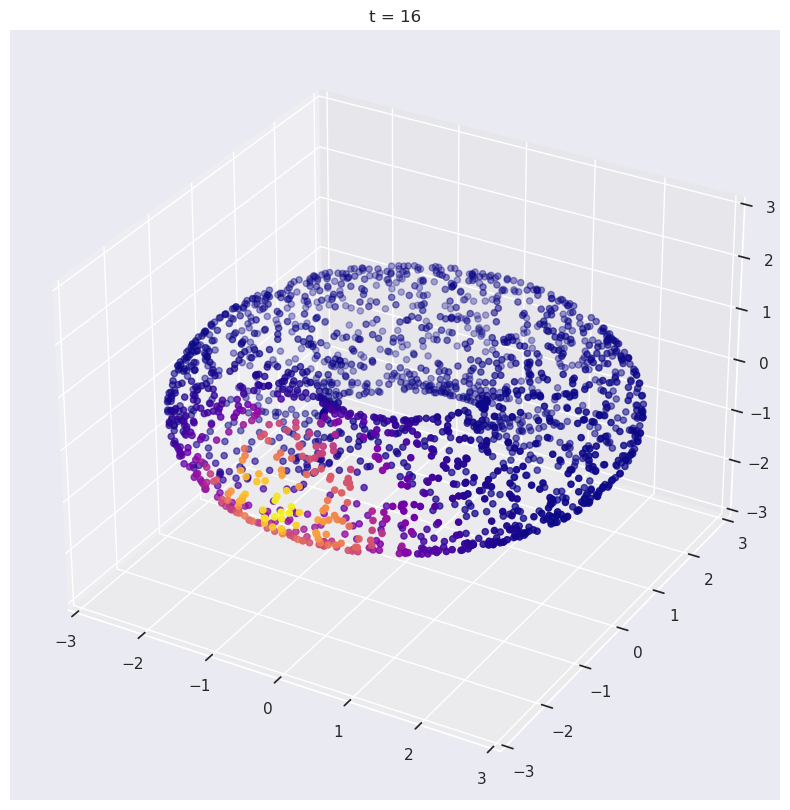

In [ ]:
plot_3d(X_torus,Pt[0], title=f"t = {t}")